# Transfer Learning on CIFAR-10 Classification
It will be implemented in the following steps:-









1.   Downloading the CIFAR-10 dataset
2.   Importing the required libraries
3.   Preparing the dataset
4.   Defining the VGG transfer learning model
5.   Training the VGG model
6.   Making Predictions
7.  Evaluating performance



In [ ]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
from keras import Sequential
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from keras.datasets import cifar10
import tensorflow as tf


In [ ]:
#Downloading the CIFAR dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# Configure GPU settings
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


# Prepare the dataset

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


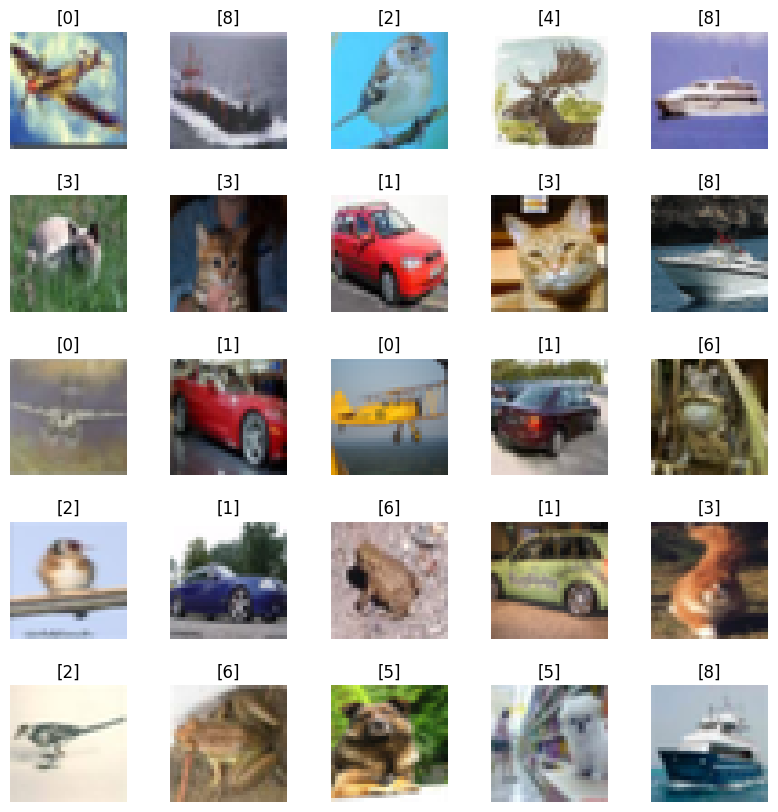

In [ ]:
W_grid = 5
L_grid = 5
fig, axes = plt.subplots(L_grid, W_grid, figsize=(10, 10))
axes = axes.ravel()
n_training = len(x_train)
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [ ]:
# Defining training and test sets

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.3)

In [ ]:
#Dimension of the dataset

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
#Onehot Encoding the labels.
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# Normalize the pixel values to the range [0, 1]
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

In [ ]:
# Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True)

val_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

In [ ]:
#Fitting the augmentation defined above to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

# Define the model

In [ ]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Building the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# Checking the final model summary
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                         

# Train the model

In [ ]:
# Train the model
# Parameters
batch_size = 100

epochs = 20

learn_rate = 0.0001

adam = Adam(lr=learn_rate)

# Compiling the model

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Learning Rate Annealer
lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.01, patience=3, min_lr=1e-5)
# Training the model
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
    validation_steps=x_val.shape[0] // batch_size,
    callbacks=[lrr],
    verbose=1
)

Epoch 1/20
350/350 [==============================] - 77s 150ms/step - loss: 2.0572 - accuracy: 0.1768 - val_loss: 1.8376 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 2/20
350/350 [==============================] - 41s 117ms/step - loss: 1.8376 - accuracy: 0.2426 - val_loss: 1.7324 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 3/20
350/350 [==============================] - 30s 86ms/step - loss: 1.7089 - accuracy: 0.3128 - val_loss: 1.6268 - val_accuracy: 0.3533 - lr: 0.0010
Epoch 4/20
350/350 [==============================] - 30s 86ms/step - loss: 1.6316 - accuracy: 0.3633 - val_loss: 1.6061 - val_accuracy: 0.3502 - lr: 0.0010
Epoch 5/20
350/350 [==============================] - 33s 95ms/step - loss: 1.5712 - accuracy: 0.3854 - val_loss: 1.5051 - val_accuracy: 0.4099 - lr: 0.0010
Epoch 6/20
350/350 [==============================] - 31s 87ms/step - loss: 1.5366 - accuracy: 0.4093 - val_loss: 1.4764 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 7/20
350/350 [==============================] - 31

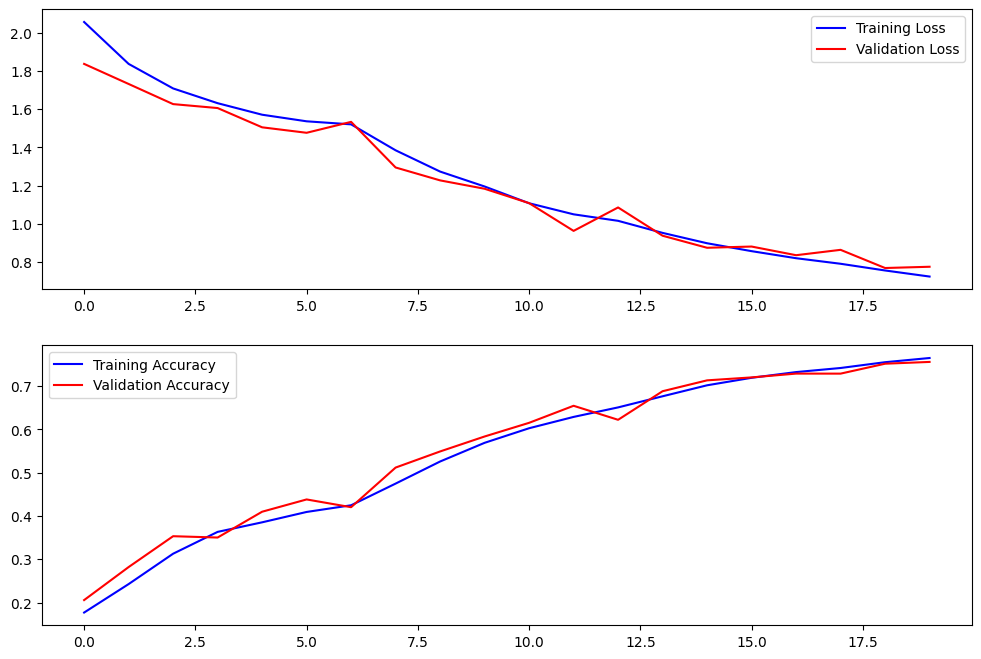

469/469 [==============================] - 6s 11ms/step - loss: 0.7741 - accuracy: 0.7562
0.7740615606307983 0.7562000155448914


In [ ]:
# Plotting the training and validation loss and accuracy
f, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'], color='b', label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].legend()
plt.show()
loss, accuracy = model.evaluate(x_val, y_val)
print(loss, accuracy)

In [ ]:
loss , accuracy = model.evaluate(x_val,y_val)

469/469 [==============================] - 5s 10ms/step - loss: 0.7741 - accuracy: 0.7562


In [ ]:
print(loss , accuracy)

0.7740615606307983 0.7562000155448914


# **Model Evaluation**

In [ ]:
# Model Evaluation
# Getting the model's predictions
y_pred = model.predict(x_val)
# Class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Convert prediction results to one hot encoded form
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

469/469 [==============================] - 4s 9ms/step


Classification Report:
               precision    recall  f1-score   support

    airplane       0.80      0.73      0.76      1520
  automobile       0.82      0.96      0.88      1527
        bird       0.76      0.61      0.67      1512
         cat       0.50      0.66      0.57      1555
        deer       0.84      0.63      0.72      1435
         dog       0.77      0.60      0.68      1478
        frog       0.76      0.88      0.82      1499
       horse       0.87      0.78      0.82      1465
        ship       0.81      0.86      0.84      1506
       truck       0.78      0.85      0.81      1503

    accuracy                           0.76     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.77      0.76      0.76     15000

Accuracy: 0.7562000155448914
F1 Score: 0.7561061415473966
ROC AUC Score: 0.9628146844178541


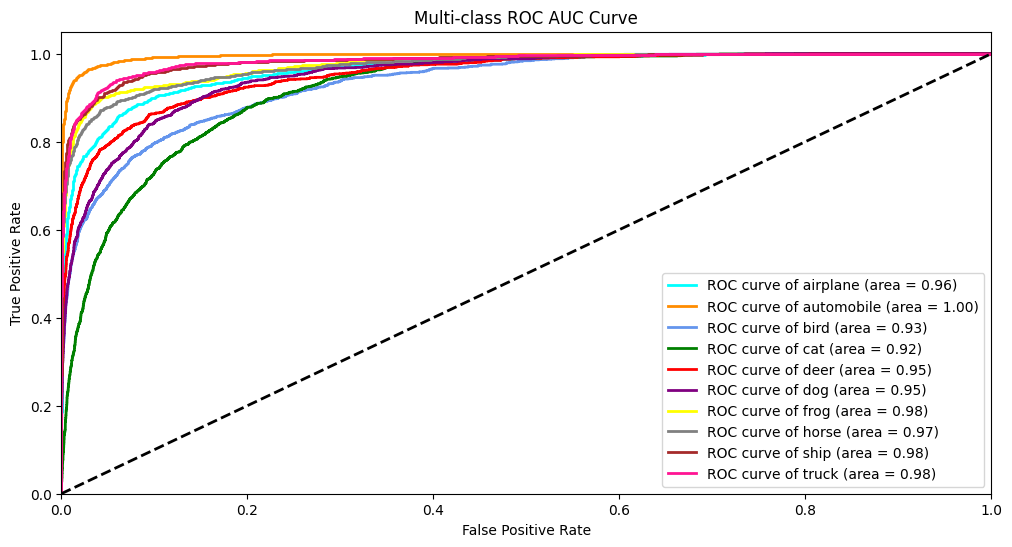

In [ ]:
# 1. Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
# 2. Accuracy (You have already printed it but let's print it again for clarity)
print("Accuracy:", accuracy)

# 3. F1 score (It's a part of the classification report but can be isolated)

print("F1 Score:", f1_score(y_true, y_pred_classes, average='macro'))

# 4. ROC AUC Score (Multi-Class)

y_val_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

n_classes = y_val_bin.shape[1]

fpr = dict()

tpr = dict()

roc_auc = dict()
for i in range(n_classes):

    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])

    roc_auc[i] = auc(fpr[i], tpr[i])

print("ROC AUC Score:", roc_auc_score(y_val, y_pred, multi_class='ovr'))
# 5. ROC AUC Curve (Multi-Class)

plt.figure(figsize=(12, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'gray', 'brown', 'deeppink'])

for i, color in zip(range(n_classes), colors):

    plt.plot(fpr[i], tpr[i], color=color, lw=2,

             label='ROC curve of {0} (area = {1:0.2f})'

             ''.format(class_names[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()